## Calculations and figures for SESA

In [1]:
## Imports
import numpy as np
import pandas as pd
import xarray as xr
import os, fnmatch
import glob
import utilities.open_data as od
import utilities.regression as reg_am
import utilities.csv2nc
import utilities.plot_sensitivity_maps
import regionmask

#Open data--------------------------------------------
ruta = '/datos/julia.mindlin/CMIP6_ensambles/preprocesados' #Dropbox/DATOS_CMIP6' #/historical/mon/tas/past'
models = [
    'ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0',
    'CanESM5', 'CESM2_', 'CESM2-WACCM','CMCC-CM2-SR5','CNRM-CM6-1',
    'CNRM-ESM2-1','EC-Earth3', 'HadGEM3-GC31-LL','HadGEM3-GC31-MM',
    'IITM-ESM','INM-CM4-8','INM-CM5-0','KACE-1-0-G',
    'MIROC6','MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
    'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1','UKESM1-0-LL'
    ]

In [2]:
import pickle
with open('/home/julia.mindlin/Tesis/JoC_paper/JoC_results/filtered_regional_precip.pkl', 'rb') as f:
    filtered_precip = pickle.load(f)


import pickle
with open('/home/julia.mindlin/Tesis/JoC_paper/JoC_results/filtered_regional_precip_ma.pkl', 'rb') as f:
    filtered_precip_ma = pickle.load(f)

import pickle
with open('/home/julia.mindlin/Tesis/JoC_paper/JoC_results/regional_precip_DJF.pkl', 'rb') as f:
    precip = pickle.load(f)
  

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
def filter_butt(xn,f):
    b, a = signal.butter(3, f)
    zi = signal.lfilter_zi(b, a)    
    z, _ = signal.lfilter(b, a, xn,zi=zi*xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    y = signal.filtfilt(b, a, xn)
    return z,z2,y 

def ma(arr,window_size):
    # Convert array of integers to pandas series
    numbers_series = pd.Series(arr)
    # Get the window of series
    # of observations of specified window size
    windows = numbers_series.rolling(window_size)
    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()
    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()
    # Remove null entries from the list
    complemento = np.ones(int(window_size/2))*moving_averages_list[0]
    #complemento2 = np.ones(int(window_size/2))*moving_averages_list[-1]
    final_list = np.array(moving_averages_list[window_size - 1:])
    return np.concatenate([complemento,final_list])

def anom(dato):
    return dato - np.mean(dato[:25])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)*4
for i in range(len(models[0:10])):
    model = models[i]
    #plt.plot(filter_butt(precip['IPCC'][model][0][10:-10])[2][30:])
    plt.plot(anom(filter_butt(precip['IPCC'][model][0][:],0.09)[2][:]),color=colors[i])
    plt.plot(anom(filter_butt(precip['IPCC'][model][0][:],0.1)[2][:]),color=colors[i])
    plt.plot(anom(precip['IPCC'][model][0][:]),color=colors[i])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)*4
for i in range(len(models[0:28])):
    model = models[i]
    #plt.plot(filter_butt(precip['IPCC'][model][0][10:-10])[2][30:])
    plt.plot(anom(filter_butt(precip['mindlin'][model][0][10:-10],.1)[2][10:]),color=colors[i])
    #plt.plot(anom(np.array(ma(precip['mindlin'][model][0][10:-10],10))[10:]),color=colors[i])


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)*4
for i in range(len(models[0:28])):
    model = models[i]
    #plt.plot(filter_butt(precip['IPCC'][model][0][10:-10])[2][30:])
    plt.plot(anom(filter_butt(precip['zilli'][model][0][10:-10],.1)[2][10:]),color=colors[i])
    #plt.plot(anom(np.array(ma(precip['mindlin'][model][0][10:-10],10))[10:]),color=colors[i])


In [3]:
#Imports
import numpy as np
import pandas as pd
import xarray as xr
import os, fnmatch
import glob

#-------------------------------------Functions--------------------------------------------
import pandas as pd
  
def ma(arr,window_size):
    # Convert array of integers to pandas series
    numbers_series = pd.Series(arr)
    # Get the window of series
    # of observations of specified window size
    windows = numbers_series.rolling(window_size)
    # Create a series of moving
    # averages of each window
    moving_averages = windows.mean()
    # Convert pandas series back to list
    moving_averages_list = moving_averages.tolist()
    # Remove null entries from the list
    final_list = moving_averages_list[window_size - 1:]
    return final_list

def anom(xn):
    return xn - xn.sel(time=slice('1940','1969')).mean(dim='time')

def gw(dato):
    tas = dato.tas
    tas.attrs = dato.tas.attrs
    tas_annual = tas.groupby('time.year').mean(dim='time')
    tas_annual = tas_annual.mean(dim='lon')
    tas_annual = tas_annual.fillna(tas_annual[-1]-1)
    lats = np.cos(tas_annual.lat.values*np.pi/180)
    s = sum(lats)
    tas_annual = (tas_annual*lats).sum(dim='lat')/s
    return tas_annual

    
#---------------------------------------Open data-----------------------------------------
path = '/datos/julia.mindlin/CMIP6_ensambles/preprocesados'
models = [
    'ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0',
    'CanESM5', 'CESM2_', 'CESM2-WACCM','CMCC-CM2-SR5','CNRM-CM6-1',
    'CNRM-ESM2-1','EC-Earth3','HadGEM3-GC31-LL','HadGEM3-GC31-MM',
    'IITM-ESM','INM-CM4-8','INM-CM5-0','KACE-1-0-G',
    'MIROC6','MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
    'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1','UKESM1-0-LL'
    ]


tas_timeseries = {}
for model in models:    
    listOfFiles_hist = os.listdir(path+'/historical/mon/tas')
    listOfFiles_ssp = os.listdir(path+'/ssp585/mon/tas')
    pattern_hist = "*"+model+"*"+'historical'+"*"+"*ensmean*"+"*T42*"
    pattern_ssp = "*"+model+"*"+'ssp585'+"*"+"*ensmean*"+"*T42*"
    for entry in listOfFiles_hist:
        if fnmatch.fnmatch(entry,pattern_hist):
            dato_hist = xr.open_dataset(path+'/historical/mon/tas/'+entry).sel(time=slice('1940','2014'))
    for entry in listOfFiles_ssp:
        if fnmatch.fnmatch(entry,pattern_ssp):
            dato_ssp = xr.open_dataset(path+'/ssp585/mon/tas/'+entry)
    merged = xr.merge([dato_hist,dato_ssp.sel(time=slice('2015','2099'))])
    tas_timeseries[model] = anom(merged)


In [ ]:
plt.plot(gw(tas_timeseries[model]))

In [ ]:
gw_year = {}
for model in models[:]:
    gw_model = gw(tas_timeseries[model])
    gw_year[model] = {}
    gw_year[model]['year'] = []
    gw_year[model]['index'] = []
    warming_levels = np.arange(0.25,5,0.25)
    for i in warming_levels:
        dif = gw_model - i
        index = (np.abs(dif)).argmin().values
        if index != 159:
            gw_year[model]['index'].append(int(index))
            gw_year[model]['year'].append(gw_model.year[int(index)].values)
        else:
            gw_year[model]['index'].append(int(index-1))
            gw_year[model]['year'].append(gw_model.year[int(index-1)].values)

In [ ]:
def anom(x):
    return x - np.mean(x[:30])

warming_levels = np.arange(0.25,5,0.25)
wet = [11,25]; dry = [8,21,22] 
for i in range(len(models)):
    model = models[i]
    if i in wet:
        plt.plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue')
    elif i in dry:
        plt.plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red')   
    else:
        plt.plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    

In [ ]:
warming_levels = np.arange(0.25,5,0.25)
wet = [12]; dry = [22]
for i in range(len(models)):
    model = models[i]
    if i in wet:
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue')
    elif i in dry:
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red')   
    else:
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    

In [ ]:
warming_levels = np.arange(0.25,5,0.25)
wet = [12]; dry = [22] 
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>1.1:
        print('wet',model,i)
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue')
    elif plot_data[-1]<-.25:
        print('dry',model,i)
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red')  
    elif plot_data[-1]>.6:
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
    elif plot_data[-1]<-.1:
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)
    else:
        plt.plot(warming_levels,anom(filter_butt(precip['mindlin'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    

In [ ]:
warming_levels = np.arange(0.25,5,0.25)
wet = [12]; dry = [22] 
for i in range(len(models)):
    model = models[i]
    if i in wet:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue')
    elif i in dry:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red')   
    elif plot_data[-1]>.6:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
    elif plot_data[-1]<-.1:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)
    else:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    

In [ ]:
warming_levels = np.arange(0.25,5,0.25)
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>1.1:
        print('wet',model,i)
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue')
    elif plot_data[-1]<-.5:
        print('dry',model,i)
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red')   
    elif plot_data[-1]>.5:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
    elif plot_data[-1]<-.1:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)
    else:
        plt.plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    

In [ ]:
warming_levels = np.arange(0.25,5,0.25)
wet = [11,25]; dry= [2,7,19] 
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>2.1:
        plt.plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue')
    elif plot_data[-1]<-1:
        print('dry',model,i)
        plt.plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red')   
    else:
        plt.plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    

### Figure

In [ ]:
## Imports
import numpy as np
import pandas as pd
import xarray as xr
import os, fnmatch
import glob
import utilities.open_data as od
import utilities.regression as reg_am
import utilities.csv2nc
import utilities.plot_sensitivity_maps
import regionmask

#Open data--------------------------------------------
ruta = '/datos/julia.mindlin/CMIP6_ensambles/preprocesados' #Dropbox/DATOS_CMIP6' #/historical/mon/tas/past'
models = [
    'ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0',
    'CanESM5', 'CESM2_', 'CESM2-WACCM','CMCC-CM2-SR5','CNRM-CM6-1',
    'CNRM-ESM2-1','EC-Earth3',  'HadGEM3-GC31-LL','HadGEM3-GC31-MM',
    'IITM-ESM','INM-CM4-8','INM-CM5-0','KACE-1-0-G',
    'MIROC6','MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
    'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1','UKESM1-0-LL'
    ]

scenarios = ['historical','ssp585']
os.chdir(ruta)
os.getcwd()

#Create dictionary
var = 'mon/pr'
dato = od.cargo_todo(scenarios,models,ruta,var)
path_indices = '/home/julia.mindlin/Tesis/BSC/indices'
#Open indices for MA season
season_name = 'DJF'
GW  = pd.read_csv(path_indices+'/GW_index_'+season_name+'.csv')
gw_DJF = GW.iloc[:,2].values


#Create regression class
reg = reg_am.across_models()
var = 'pr'
#Generate regression data
reg.regression_data(dato,scenarios,models,gw_DJF,var)
pr_change = reg.psl_change

## Precipitation change under each storyline using different boxes
path_maps = '/home/julia.mindlin/Tesis/BSC/sensitivity_maps/DJF/pr'
GW = pr_change[0]

#Box from paper 2020
mask_mindlin = GW.where(GW.lon<305).where(GW.lon>292).where(GW.lat>-42).where(GW.lat<-27) / GW.where(GW.lon<305).where(GW.lon>292).where(GW.lat>-42).where(GW.lat<-27)
#mask_mindlin = mask_mindlin.reindex(lat=list(reversed(mask_mindlin.lat)))
#Box from IPCC
import regionmask
mask_IPCC = regionmask.defined_regions.ar6.land.mask(GW).where(regionmask.defined_regions.ar6.land.mask(GW) == 14)/14
#mask_IPCC = mask_IPCC.reindex(lat=list(reversed(mask_IPCC.lat)))
#Box from paper Lean
#38.75∘S–26.25∘S, 66.25–61.25∘W
mask_diaz = GW.where(GW.lon<298.75).where(GW.lon>293.75).where(GW.lat>-38.75).where(GW.lat<-26.25) / GW.where(GW.lon<298.75).where(GW.lon>293.75).where(GW.lat>-38.75).where(GW.lat<-26.25)
#mask_diaz = mask_diaz.reindex(lat=list(reversed(mask_diaz.lat)))
#Box from Clementine
#32°S:25°S,60°W:50°W
mask_junquas = GW.where(GW.lon<310).where(GW.lon>300).where(GW.lat>-32).where(GW.lat<-25) / GW.where(GW.lon<310).where(GW.lon>300).where(GW.lat>-32).where(GW.lat<-25)
#mask_junquas = mask_junquas.reindex(lat=list(reversed(mask_junquas.lat)))
#Box from Clementine
#32°S:25°S,60°W:50°W  
mask_zilli = GW.where(GW.lon<320).where(GW.lon>311).where(GW.lat>-25).where(GW.lat<-20) / GW.where(GW.lon<310).where(GW.lon>300).where(GW.lat>-32).where(GW.lat<-25)
#mask_junquas = mask_junquas.reindex(lat=list(reversed(mask_junquas.lat)))
#Box from Paula
#32°S:25°S,60°W:50°W  
mask_gonzalez = GW.where(GW.lon<315).where(GW.lon>295).where(GW.lat>-40).where(GW.lat<-20) / GW.where(GW.lon<295).where(GW.lon>315).where(GW.lat>-40).where(GW.lat<-20)

#Boxplot precip changes in each box for each model and each storyline
SESA_changes = {}
SESA_changes['IPCC'] = []
SESA_changes['mindlin'] = []
SESA_changes['diaz'] = []
SESA_changes['junquas'] = []
SESA_changes['zilli'] = []
SESA_changes['gonzalez'] = []
for i in range(len(models)):
    A = mask_IPCC.values*pr_change[i].values*86400
    IPCC_mean = A[~np.isnan(A)].mean() 
    SESA_changes['IPCC'].append(IPCC_mean)
    SESA_changes['mindlin'].append((pr_change[i].sel(lon=slice(292,305)).sel(lat=slice(-27,-42))*86400).mean(dim='lon').mean(dim='lat').values)
    SESA_changes['diaz'].append((pr_change[i].sel(lon=slice(293.75,298.75)).sel(lat=slice(-26.25,-38.75))*86400).mean(dim='lon').mean(dim='lat').values)
    SESA_changes['junquas'].append((pr_change[i].sel(lon=slice(300,310)).sel(lat=slice(-25,-32))*86400).mean(dim='lon').mean(dim='lat').values)
    SESA_changes['zilli'].append((pr_change[i].sel(lon=slice(311,320)).sel(lat=slice(-20,-25))*86400).mean(dim='lon').mean(dim='lat').values)
    SESA_changes['gonzalez'].append((pr_change[i].sel(lon=slice(295,315)).sel(lat=slice(-20,-40))*86400).mean(dim='lon').mean(dim='lat').values)
    

In [ ]:
#Cargo los indices de RDs
path_indices = '/home/julia.mindlin/Tesis/BSC/indices'
#Open indices for MA season
season_name = 'DJF'
GW  = pd.read_csv(path_indices+'/GW_index_'+season_name+'.csv')
gw_DJF = GW.iloc[:,2].values
E_index  = pd.read_csv(path_indices+'/E_std_asym_index_'+season_name+'.csv')
e_index_DJF = E_index.iloc[:,2]
C_index = pd.read_csv(path_indices+'/C_std_asym_index_'+season_name+'.csv')
c_index_DJF = C_index.iloc[:,2]
TW = pd.read_csv(path_indices+'/TW_index_'+season_name+'.csv')
tw_DJF = TW.iloc[:,2]
VB = pd.read_csv(path_indices+'/VB_regresion_coef_all_models.csv')
vb =  VB.iloc[:,2]

tw_DJF = tw_DJF/gw_DJF
def std(index):
    return (index - np.mean(index))/np.std(index)

In [ ]:
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
import xarray as xr 
import numpy as np 

path_maps = '/home/julia.mindlin/Tesis/BSC/sensitivity_maps/DJF/pr'
#path_maps = '/home/julia.mindlin/Tesis/Capitulo3/scripts/CMIP6_storylines/DJF/sensitivity_maps/pr/C_E_std_max'
#Create sensitivity maps
path_fig = '/home/julia.mindlin/Tesis/Capitulo3/scripts/CMIP6_storylines/DJF/paper_figures'

#Create plots
GlobalWarming = xr.open_dataset(path_maps+'/Aij.nc')*86400
TropicalWarming = xr.open_dataset(path_maps+'/TAij.nc')*86400
VorBreak_GW = xr.open_dataset(path_maps+'/VBij.nc')*86400
SST_C = xr.open_dataset(path_maps+'/SST_1ij.nc')*86400
SST_E = xr.open_dataset(path_maps+'/SST_2ij.nc')*86400

GlobalWarmingp = xr.open_dataset(path_maps+'/Apij.nc')
TropicalWarmingp = xr.open_dataset(path_maps+'/TApij.nc')
VorBreak_GWp = xr.open_dataset(path_maps+'/VBpij.nc')
SST_Cp = xr.open_dataset(path_maps+'/SST_1pij.nc')
SST_Ep = xr.open_dataset(path_maps+'/SST_2pij.nc')

In [9]:
mask_IPCC.sel(lat=slice(-18,-41)).sel(lon=slice(290,326)).plot()

NameError: name 'mask_IPCC' is not defined

In [8]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(12,8))
GW = np.array([0,1,2,3,4,5,6])
ts = 1.22
A = mask_IPCC.values*GlobalWarming.coef.values
GW_IPCC_mean = A[~np.isnan(A)].mean() 
A = mask_IPCC.values*TropicalWarming.coef.values
TW_IPCC_mean = A[~np.isnan(A)].mean() 
A = mask_IPCC.values*SST_C.coef.values
SST_C_IPCC_mean = A[~np.isnan(A)].mean() 
A = mask_IPCC.values*SST_E.coef.values
SST_E_IPCC_mean = A[~np.isnan(A)].mean() 
A = mask_IPCC.values*VorBreak_GW.coef.values
VB_IPCC_mean = A[~np.isnan(A)].mean() 
for m in range(len(models)):
    GW_model = np.linspace(0,gw_DJF[m],10)
    plt.plot(GW_model,GW_model*SESA_changes['IPCC'][m],color='grey')
    plt.plot(GW,GW*GW_IPCC_mean*ts,color='red')
    plt.plot(GW,GW*(- TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle='dashed')
    plt.plot(GW,GW*(VB_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle=(0, (3, 5, 1, 5, 1, 5)))
    plt.plot(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle='dotted')
    plt.plot(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle='dashdot')
    plt.plot(GW,GW*(TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle='dashed')
    plt.plot(GW,GW*(-VB_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)))
    plt.plot(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle='dotted')
    plt.plot(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean - SST_E_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle='dashdot')
            

NameError: name 'mask_IPCC' is not defined

<Figure size 1200x800 with 0 Axes>

In [7]:
from global_land_mask import globe
path_GPCP = '/datos'
precip_gpcp = xr.open_dataset(path_GPCP+'/precip.mon.mean.GPCP.nc')

lat = precip_gpcp.lat.values
lon = precip_gpcp.lon.values - 180
lon_grid, lat_grid = np.meshgrid(lon,lat)
globe_land_mask = globe.is_land(lat_grid, lon_grid)

def land_masked_field(dato):
    masked = dato*globe_land_mask
    return masked.where(masked != 0)

precip_DJF_1989_2018 = (precip_gpcp.sel(time=slice('1989','2018')).precip/30).groupby('time.season').mean(dim='time').sel(season='DJF')
precip_DJF_1989_2018.attrs = precip_gpcp.precip.attrs
precip_DJF_1950_1979 = (precip_gpcp.sel(time=slice('1950','1979')).precip/30).groupby('time.season').mean(dim='time').sel(season='DJF')
precip_DJF_1950_1979.attrs = precip_gpcp.precip.attrs

ModuleNotFoundError: No module named 'global_land_mask'

In [4]:
ax[0].plot(GW,GW*(- TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle='dashed',linewidth=2.5)
ax[0].plot(GW,GW*(VB_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[0].plot(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle='dotted',linewidth=2.5)
ax[0].plot(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linestyle='dashdot',linewidth=2.5)
ax[0].plot(GW,GW*(TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle='dashed',linewidth=2.5)
ax[0].plot(GW,GW*(-VB_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[0].plot(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle='dotted',linewidth=2.5)
ax[0].plot(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean - SST_E_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linestyle='dashdot',linewidth=2.5)


NameError: name 'ax' is not defined

NameError: name 'GW_IPCC_mean' is not defined

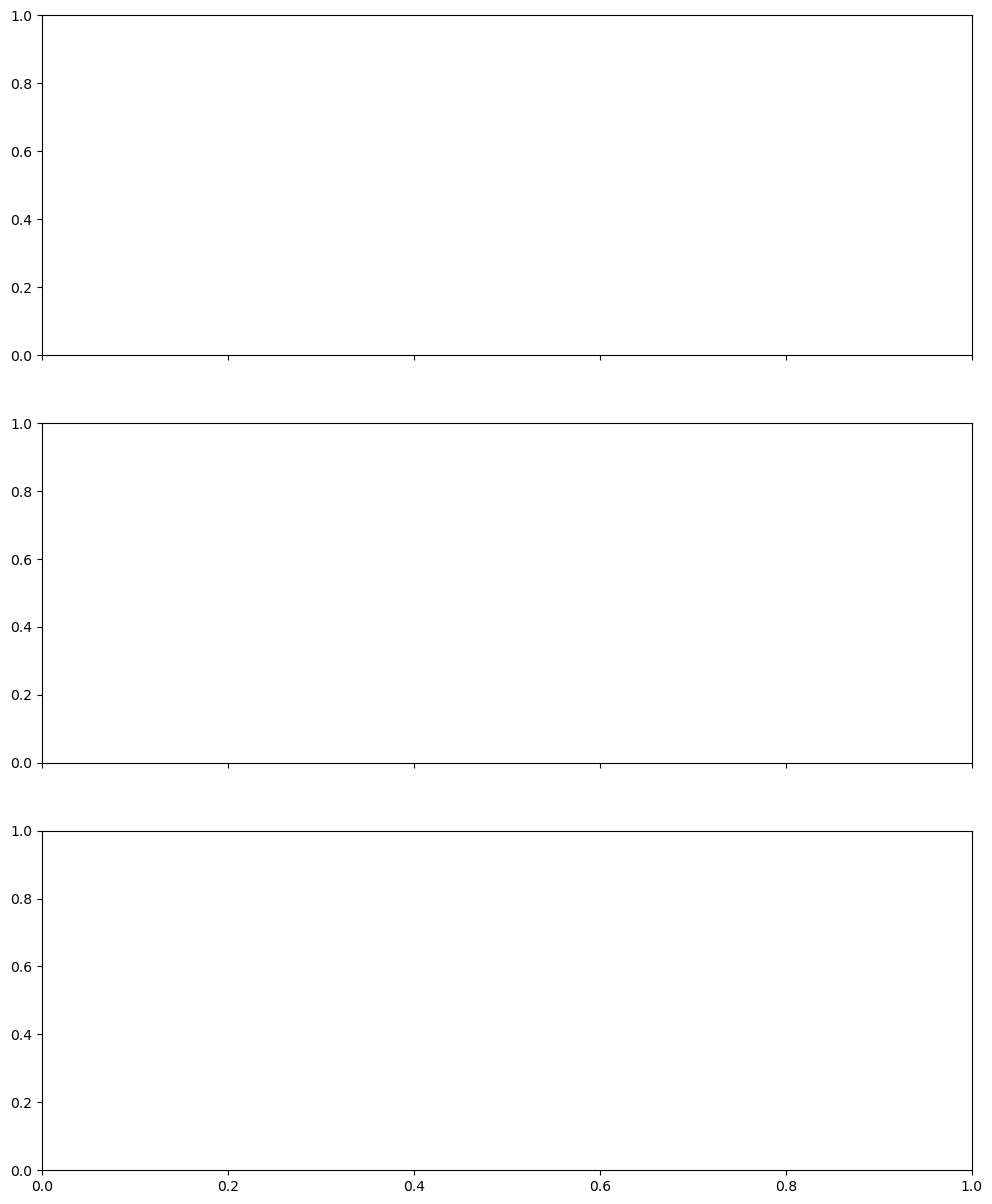

In [5]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3, sharex='col', sharey='row',figsize=(12,15))
GW = np.array([0,1,2,3,4,5])
ts = 1.22
ax[0].plot(GW,GW*GW_IPCC_mean*ts,color='red')
ax[0].set_title('Region A',fontsize=20)
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>.8:
        ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
        j = i
    elif plot_data[-1]<-.5:
        ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5) 
        m = i
    else:
        if i == 4:
            ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5,label='CMIP6 models')
        else:
            ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
            
ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][models[j]][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5,label='wet CMIP6 models')
ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][models[m]][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5,label='dry CMIP6 models')
observed_rate = (land_masked_field(precip_DJF_1989_2018).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat') - land_masked_field(precip_DJF_1950_1979).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat')).values/.8
ax[0].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5,label='extrapolated observed trend (GPCP)')
ax[0].hlines(0,0,7,color='k',linewidth=0.5,linestyle='dashed')
ax[0].plot(GW,GW*GW_IPCC_mean,color='k',linewidth=2.5,label='CMIP6 ensemble mean')
ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='k',linewidth=2.5,linestyle='--',label='TW')
ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5,label = 'TW,VB')
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',linestyle='dotted',linewidth=2.5,label = 'TW,VB,CP')
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',linestyle='dashdot',linewidth=2.5,label = 'TW,VB,CP,EP')
ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='blue',linewidth=2.5,linestyle='--')
ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle='dotted',linewidth=2.5)
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle='dashdot',linewidth=2.5)
ts = -1.22
ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='red',linewidth=2.5,linestyle='--')
ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle=(0, (3, 5, 1, 5, 1, 5)))
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=2.5,linestyle='dotted')
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle='dashdot')
#Scatter
ts = 1.22
ax[0].grid(True)
ax[0].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
ax[0].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=False,
               left=False, right=False, labelleft=True)
ax[0].set_ylim(-3.2,3)

box = [300,310,-32,-25]
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>1.6:
        ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
    elif plot_data[-1]<-.5:
        print('dry',model,i)
        ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)   
    else:
        ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
ax[1].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
ax[1].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
ax[1].plot(GW,GW*GlobalWarming.coef.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='k',linewidth=2.5)
ax[1].plot(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashed',linewidth=2.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef + SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dotted',linewidth=2.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef + SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashdot',linewidth=2.5)
ax[1].plot(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashed',linewidth=2.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dotted',linewidth=2.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef - SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashdot',linewidth=2.5)
#High and low trend storyline Monte Carlo 

high_junquas_tw= 0.5986530871608174;high_junquas_vb=-0.9536197883232482;high_junquas_ep =-0.4711541232863085;high_junquas_cp = -2.275507433106914
low_junquas_tw= -0.5488707401959659;low_junquas_vb=0.994107376355804;low_junquas_ep = 0.33825280731954904;low_junquas_cp = 2.24965522403902

ax[1].plot(GW,GW*(VorBreak_GW.coef*low_junquas_vb + SST_C.coef*low_junquas_cp - SST_E.coef*low_junquas_ep + TropicalWarming.coef*low_junquas_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='solid',linewidth=5,alpha=0.6,label='mean wet storyline')
ax[1].plot(GW,GW*(VorBreak_GW.coef*high_junquas_vb + SST_C.coef*high_junquas_cp - SST_E.coef*high_junquas_ep + TropicalWarming.coef*high_junquas_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='solid',linewidth=5,alpha=0.6,label='mean dry storyline')
ax[1].set_title('Region B',fontsize=20)
ax[1].grid(True)
ax[1].set_ylim(-3.2,3)
ax[1].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=False,
               left=False, right=False, labelleft=True)
ax[1].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)

box = [311,320,-25,-20]
#for m in range(len(models)):
    #GW_model = np.linspace(0,gw_DJF[m],10)
    #plt.plot(GW_model,GW_model*SESA_changes['zilli'][m],color='grey')
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>2.1:
        ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
    elif plot_data[-1]<-1:
        print('dry',model,i)
        ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)   
    else:
        ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
ax[2].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
ax[2].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
ax[2].plot(GW,GW*GlobalWarming.coef.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='k',linewidth=2.5)
ax[2].plot(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashed',linewidth=2.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dotted',linewidth=2.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashdot',linewidth=2.5)
ax[2].plot(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashed',linewidth=2.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + SST_C.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dotted',linewidth=2.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashdot',linewidth=2.5)
#High and low trend storyline Monte Carlo 
high_zilli_tw= 0.5062185071751433;high_zilli_vb=-2.1579785281287713;high_zilli_ep =-1.0045553953777357;high_zilli_cp = 1.0901145402994015
low_zilli_tw= -0.5828935295244692,;low_zilli_vb=2.1198275551684738;low_zilli_ep = 0.9480826958470476;low_zilli_cp = -1.1237449563080393

ax[2].plot(GW,GW*(VorBreak_GW.coef*low_zilli_vb + SST_C.coef*low_zilli_cp - SST_E.coef*low_zilli_ep + TropicalWarming.coef*low_zilli_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='solid',linewidth=5,alpha=0.6,label='mean wet storyline')
ax[2].plot(GW,GW*(VorBreak_GW.coef*high_zilli_vb + SST_C.coef*high_zilli_cp - SST_E.coef*high_zilli_ep + TropicalWarming.coef*high_zilli_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='solid',linewidth=5,alpha=0.6,label='mean dry storyline')
ax[2].set_title('Region F',fontsize=20)
ax[2].grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.7)


ax[2].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)
ax[2].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
ax[2].set_xlabel(r'$\Delta$ T [K]',fontsize=24)
ax[2].set_xlim(.25,4.5)
ax[2].set_ylim(-3.2,3)
ax[0].legend(loc='upper left',ncol=4)
ax[1].legend(loc='upper left',ncol=4)
ax[2].legend(loc='upper left',ncol=4)
plt.show()



NameError: name 'GW_IPCC_mean' is not defined

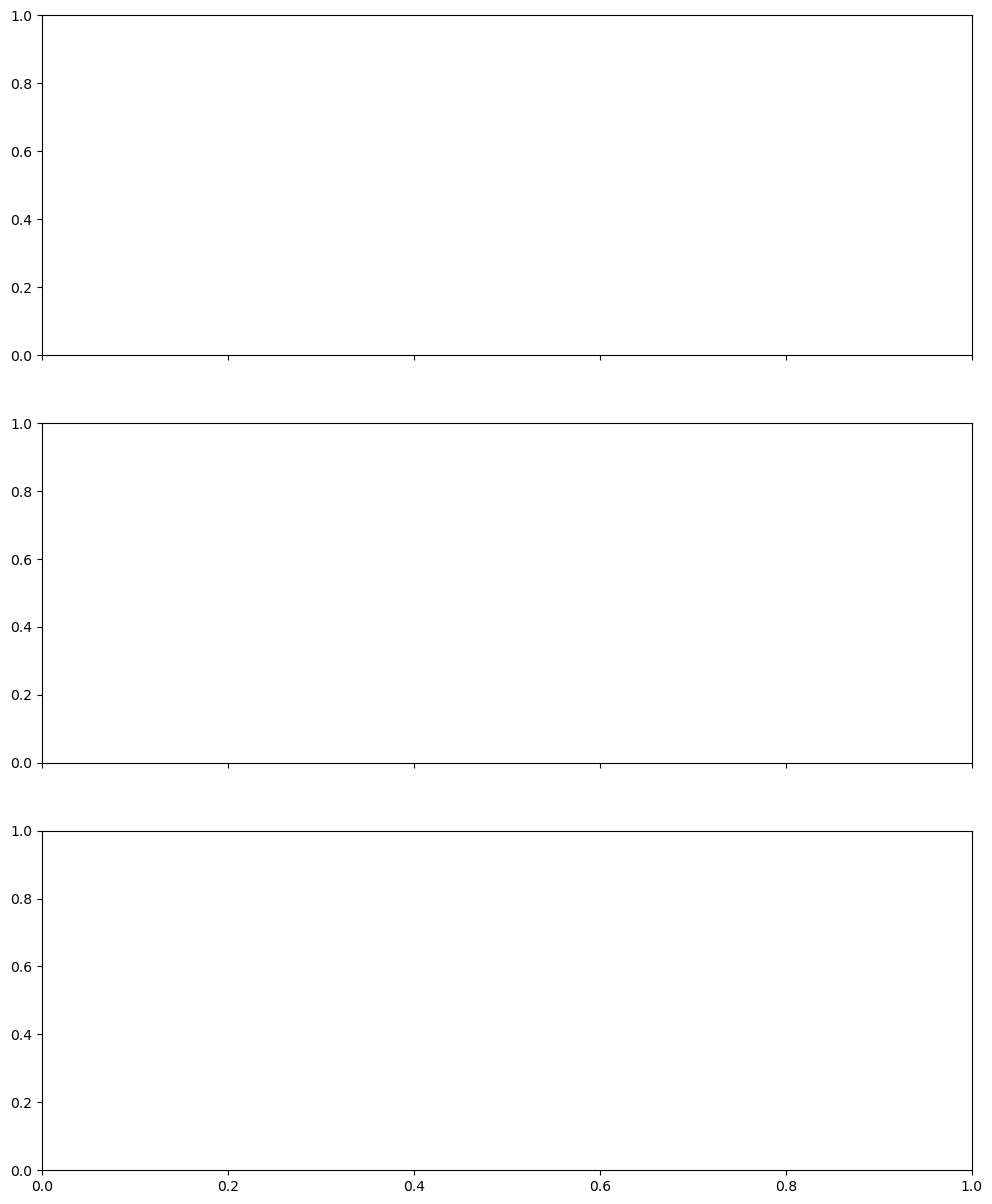

In [5]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3, sharex='col', sharey='row',figsize=(12,15))
GW = np.array([0,1,2,3,4,5])
ts = 1.22
ax[0].plot(GW,GW*GW_IPCC_mean*ts,color='red')
ax[0].set_title('Region A',fontsize=20)
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>.8:
        ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
        j = i
    elif plot_data[-1]<-.5:
        ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5) 
        m = i
    else:
        if i == 4:
            ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5,label='CMIP6 models')
        else:
            ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
            
ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][models[j]][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5,label='wet CMIP6 models')
ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][models[m]][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5,label='dry CMIP6 models')
observed_rate = (land_masked_field(precip_DJF_1989_2018).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat') - land_masked_field(precip_DJF_1950_1979).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat')).values/.8
ax[0].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5,label='extrapolated observed trend (GPCP)')
ax[0].hlines(0,0,7,color='k',linewidth=0.5,linestyle='dashed')
ax[0].plot(GW,GW*GW_IPCC_mean,color='k',linewidth=2.5,label='CMIP6 ensemble mean')
ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='k',linewidth=2.5,linestyle='--',label='TW')
ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5,label = 'TW,VB')
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',linestyle='dotted',linewidth=2.5,label = 'TW,VB,CP')
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',linestyle='dashdot',linewidth=2.5,label = 'TW,VB,CP,EP')
ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='blue',linewidth=2.5,linestyle='--')
ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle='dotted',linewidth=2.5)
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle='dashdot',linewidth=2.5)
ts = -1.22
ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='red',linewidth=2.5,linestyle='--')
ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle=(0, (3, 5, 1, 5, 1, 5)))
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=2.5,linestyle='dotted')
ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle='dashdot')
#Scatter
ts = 1.22
ax[0].grid(True)
ax[0].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
ax[0].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=False,
               left=False, right=False, labelleft=True)
ax[0].set_ylim(-3.2,3)

box = [300,310,-32,-25]
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>1.6:
        ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
    elif plot_data[-1]<-.5:
        print('dry',model,i)
        ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)   
    else:
        ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
ax[1].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
ax[1].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
ax[1].plot(GW,GW*GlobalWarming.coef.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='k',linewidth=2.5)
ax[1].plot(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashed',linewidth=2.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef + SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dotted',linewidth=2.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef + SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashdot',linewidth=2.5)
ax[1].plot(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashed',linewidth=2.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dotted',linewidth=2.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef - SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashdot',linewidth=2.5)
#High and low trend storyline Monte Carlo 

high_junquas_tw= 0.5986530871608174;high_junquas_vb=-0.9536197883232482;high_junquas_ep =-0.4711541232863085;high_junquas_cp = -2.275507433106914
low_junquas_tw= -0.5488707401959659;low_junquas_vb=0.994107376355804;low_junquas_ep = 0.33825280731954904;low_junquas_cp = 2.24965522403902

ax[1].plot(GW,GW*(VorBreak_GW.coef*low_junquas_vb + SST_C.coef*low_junquas_cp - SST_E.coef*low_junquas_ep + TropicalWarming.coef*low_junquas_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='solid',linewidth=5,alpha=0.6,label='mean wet storyline')
ax[1].plot(GW,GW*(VorBreak_GW.coef*high_junquas_vb + SST_C.coef*high_junquas_cp - SST_E.coef*high_junquas_ep + TropicalWarming.coef*high_junquas_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='solid',linewidth=5,alpha=0.6,label='mean dry storyline')
ax[1].set_title('Region B',fontsize=20)
ax[1].grid(True)
ax[1].set_ylim(-3.2,3)
ax[1].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=False,
               left=False, right=False, labelleft=True)
ax[1].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)

box = [311,320,-25,-20]
#for m in range(len(models)):
    #GW_model = np.linspace(0,gw_DJF[m],10)
    #plt.plot(GW_model,GW_model*SESA_changes['zilli'][m],color='grey')
for i in range(len(models)):
    model = models[i]
    plot_data = anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']]
    if plot_data[-1]>2.1:
        ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
    elif plot_data[-1]<-1:
        print('dry',model,i)
        ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)   
    else:
        ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
ax[2].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
ax[2].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
ax[2].plot(GW,GW*GlobalWarming.coef.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='k',linewidth=2.5)
ax[2].plot(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashed',linewidth=2.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dotted',linewidth=2.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='dashdot',linewidth=2.5)
ax[2].plot(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashed',linewidth=2.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle=(0, (3, 5, 1, 5, 1, 5)),linewidth=2.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + SST_C.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dotted',linewidth=2.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='dashdot',linewidth=2.5)
#High and low trend storyline Monte Carlo 
high_zilli_tw= 0.5062185071751433;high_zilli_vb=-2.1579785281287713;high_zilli_ep =-1.0045553953777357;high_zilli_cp = 1.0901145402994015
low_zilli_tw= -0.5828935295244692,;low_zilli_vb=2.1198275551684738;low_zilli_ep = 0.9480826958470476;low_zilli_cp = -1.1237449563080393

ax[2].plot(GW,GW*(VorBreak_GW.coef*low_zilli_vb + SST_C.coef*low_zilli_cp - SST_E.coef*low_zilli_ep + TropicalWarming.coef*low_zilli_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='solid',linewidth=5,alpha=0.6,label='mean wet storyline')
ax[2].plot(GW,GW*(VorBreak_GW.coef*high_zilli_vb + SST_C.coef*high_zilli_cp - SST_E.coef*high_zilli_ep + TropicalWarming.coef*high_zilli_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='solid',linewidth=5,alpha=0.6,label='mean dry storyline')
ax[2].set_title('Region F',fontsize=20)
ax[2].grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.7)


ax[2].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)
ax[2].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
ax[2].set_xlabel(r'$\Delta$ T [K]',fontsize=24)
ax[2].set_xlim(.25,4.5)
ax[2].set_ylim(-3.2,3)
ax[0].legend(loc='upper left',ncol=4)
ax[1].legend(loc='upper left',ncol=4)
ax[2].legend(loc='upper left',ncol=4)
plt.show()



NameError: name 'GW_IPCC_mean' is not defined

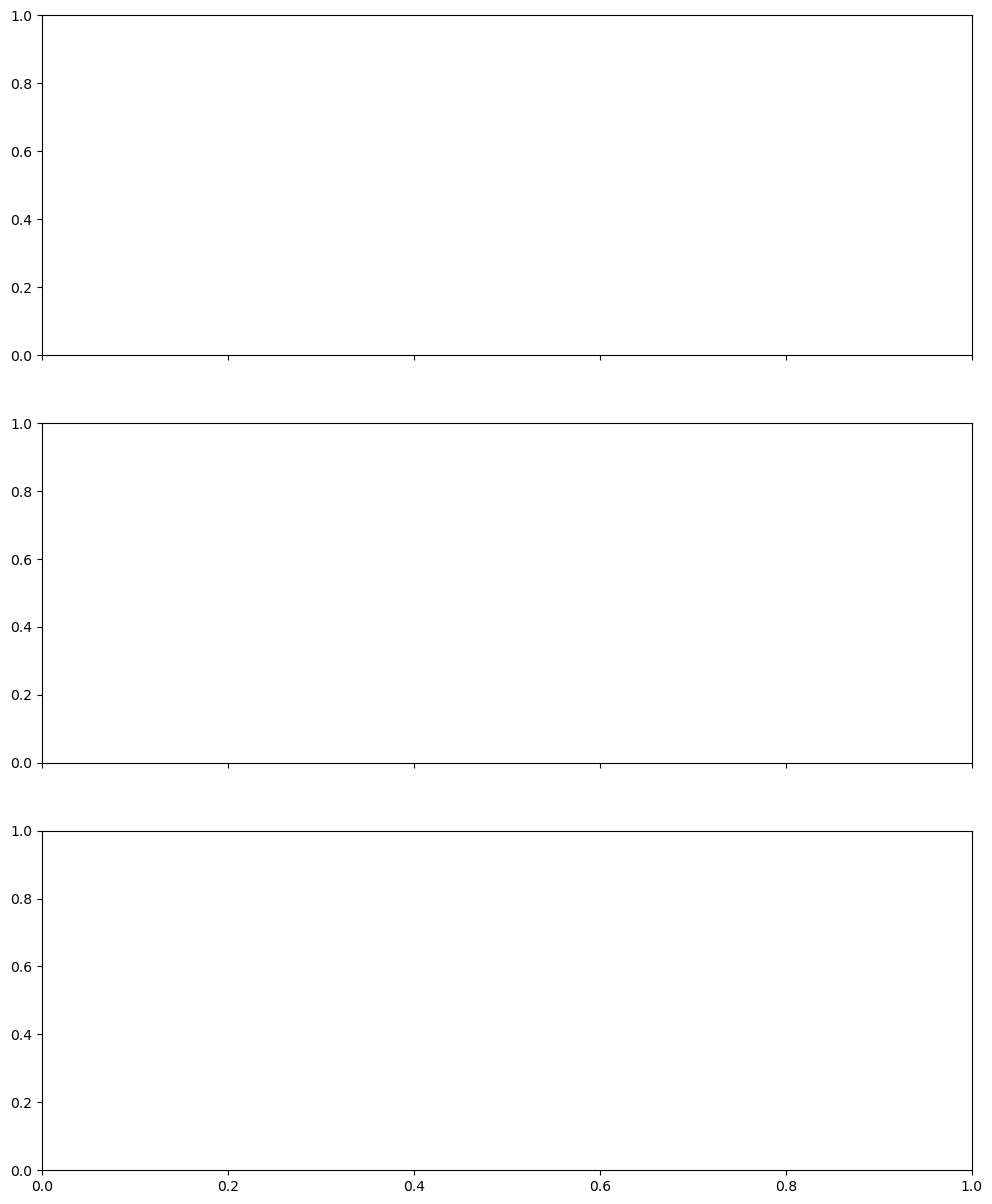

In [6]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3, sharex='col', sharey='row',figsize=(12,15))

GW = np.array([0,1,2,3,4,5,6])
ts = 1.22
ax[0].plot(GW,GW*GW_IPCC_mean*ts,color='red')
ax[0].set_title('Region A',fontsize=20)
for m in range(len(models)):
    GW_model = np.linspace(0,gw_DJF[m],10)
    ax[0].plot(GW_model,GW_model*SESA_changes['IPCC'][m],color='grey')
ax[0].plot(GW_model,GW_model*SESA_changes['IPCC'][m],color='grey',label='CMIP6 models')
observed_rate = (land_masked_field(precip_DJF_1989_2018).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat') - land_masked_field(precip_DJF_1950_1979).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat')).values/.8
ax[0].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5,label='extrapolated observed trend (GPCP)')
ax[0].hlines(0,0,7,color='k',linewidth=0.5,linestyle='dashed')
ax[0].plot(GW,GW*GW_IPCC_mean*ts,color='k',linewidth=2.5,label='CMIP6 ensemble mean')
ax[0].plot(GW,GW*(- TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linewidth=1.5,label='wet storyline ts = 1.22')
ax[0].plot(GW,GW*(VB_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linewidth=1.5)
ax[0].plot(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linewidth=1.5)
ax[0].plot(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',linewidth=1.5)
ax[0].plot(GW,GW*(TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linewidth=1.5,label = 'dry storyline ts = -1.22')
ax[0].plot(GW,GW*(-VB_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linewidth=1.5)
ax[0].plot(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linewidth=1.5)
ax[0].plot(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean - SST_E_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',linewidth=1.5)
#Scatter
ax[0].scatter(GW,GW*(- TW_IPCC_mean + GW_IPCC_mean)*ts,color='k',marker='x',linewidth=1.5,label = 'TW')
ax[0].scatter(GW,GW*(VB_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='k',marker='o',linewidth=1.5,label = 'TW,VB')
ax[0].scatter(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='k',marker='v',linewidth=1.5,label = 'TW,VB,CP')
ax[0].scatter(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='k',marker='D',linewidth=1.5,label = 'TW,VB,CP,EP')
ax[0].scatter(GW,GW*(- TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',marker='x',linewidth=1.5)
ax[0].scatter(GW,GW*(VB_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',marker='o',linewidth=1.5)
ax[0].scatter(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',marker='v',linewidth=1.5)
ax[0].scatter(GW,GW*(VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean + GW_IPCC_mean)*ts,color='red',marker='D',linewidth=1.5)
ax[0].scatter(GW,GW*(TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',marker='x',linewidth=1.5)
ax[0].scatter(GW,GW*(-VB_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',marker='o',linewidth=1.5)
ax[0].scatter(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',marker='v',linewidth=1.5)
ax[0].scatter(GW,GW*(-VB_IPCC_mean - SST_C_IPCC_mean - SST_E_IPCC_mean + TW_IPCC_mean + GW_IPCC_mean)*ts,color='blue',marker='D',linewidth=1.5)
ax[0].set_ylim(-1,2)
ax[0].grid(True)
ax[0].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
ax[0].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=False,
               left=False, right=False, labelleft=True)

box = [300,310,-32,-25]
for m in range(len(models)):
    GW_model = np.linspace(0,gw_DJF[m],10)
    ax[1].plot(GW_model,GW_model*SESA_changes['junquas'][m],color='grey')
ax[1].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
ax[1].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
ax[1].plot(GW,GW*GlobalWarming.coef.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='k',linewidth=2.5)
ax[1].plot(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef + SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[1].plot(GW,GW*(VorBreak_GW.coef + SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[1].plot(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
ax[1].plot(GW,GW*(-VorBreak_GW.coef - SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
#Scatter
ax[1].scatter(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='x',linewidth=1.5)
ax[1].scatter(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='o',linewidth=1.5)
ax[1].scatter(GW,GW*(VorBreak_GW.coef + SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='v',linewidth=1.5)
ax[1].scatter(GW,GW*(VorBreak_GW.coef + SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='D',linewidth=1.5)
ax[1].scatter(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='x',linewidth=1.5)
ax[1].scatter(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='o',linewidth=1.5)
ax[1].scatter(GW,GW*(-VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='v',linewidth=1.5)
ax[1].scatter(GW,GW*(-VorBreak_GW.coef - SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='D',linewidth=1.5)

ax[1].set_title('Region B',fontsize=20)
ax[1].grid(True)
ax[1].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=False,
               left=False, right=False, labelleft=True)
ax[1].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)

box = [311,320,-25,-20]
for m in range(len(models)):
    GW_model = np.linspace(0,gw_DJF[m],10)
    plt.plot(GW_model,GW_model*SESA_changes['zilli'][m],color='grey')
ax[2].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
ax[2].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
ax[2].plot(GW,GW*GlobalWarming.coef.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='k',linewidth=2.5)
ax[2].plot(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[2].plot(GW,GW*(VorBreak_GW.coef - SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linewidth=1.5)
ax[2].scatter(GW,GW*(- TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='x',linewidth=1.5)
ax[2].scatter(GW,GW*(VorBreak_GW.coef - TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='o',linewidth=1.5)
ax[2].scatter(GW,GW*(VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='v',linewidth=1.5)
ax[2].scatter(GW,GW*(VorBreak_GW.coef - SST_C.coef + SST_E.coef -TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',marker='D',linewidth=1.5)

ax[2].plot(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + SST_C.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
ax[2].plot(GW,GW*(-VorBreak_GW.coef + SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linewidth=1.5)
ax[2].scatter(GW,GW*(TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='x',linewidth=1.5)
ax[2].scatter(GW,GW*(-VorBreak_GW.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='o',linewidth=1.5)
ax[2].scatter(GW,GW*(-VorBreak_GW.coef + SST_C.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='v',linewidth=1.5)
ax[2].scatter(GW,GW*(-VorBreak_GW.coef + SST_C.coef - SST_E.coef + TropicalWarming.coef + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',marker='D',linewidth=1.5)
ax[2].set_title('Region F',fontsize=20)
ax[2].grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.7)


ax[2].tick_params(axis='both', which='both', labelsize=18,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)
ax[2].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
ax[2].set_xlabel(r'$\Delta$ T [K]',fontsize=24)
ax[2].set_xlim(0,7)
ax[0].legend(loc='upper left',ncol=4)
plt.show()



In [ ]:
#------------------------------------------------------FIGURE---------------------------------------------------------------------
def figure():
    fig, ax = plt.subplots(3, sharex='col', sharey='row',figsize=(12,15))

    GW = np.array([0,1,2,3,4,5,6])
    ts = 1.22
    ax[0].plot(GW,GW*GW_IPCC_mean*ts,color='red')
    ax[0].set_title('Region A',fontsize=20)
    for m in range(len(models)):
        GW_model = np.linspace(0,gw_DJF[m],10)
        ax[0].plot(GW_model,GW_model*SESA_changes['IPCC'][m],color='grey')
    ax[0].plot(GW_model,GW_model*SESA_changes['IPCC'][m],color='grey',label='CMIP6 models')
    observed_rate = (land_masked_field(precip_DJF_1989_2018).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat') - land_masked_field(precip_DJF_1950_1979).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat')).values/.8
    ax[0].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5,label='extrapolated observed trend (GPCP)')
    ax[0].hlines(0,0,7,color='k',linewidth=0.5,linestyle='dashed')
    ax[0].plot(GW,GW*GW_IPCC_mean,color='k',linewidth=2.5,label='CMIP6 ensemble mean')
    ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='red',linewidth=1.5,label='wet storyline ts = 1.22')
    ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5)
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5)
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5)
    ts = -1.22
    ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='blue',linewidth=1.5,label = 'dry storyline ts = -1.22')
    ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linewidth=1.5)
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linewidth=1.5)
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linewidth=1.5)
    #Scatter
    ts = 1.22
    ax[0].scatter(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='k',marker='x',linewidth=1.5,label = 'TW')
    ax[0].scatter(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',marker='o',linewidth=1.5,label = 'TW,VB')
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',marker='v',linewidth=1.5,label = 'TW,VB,CP')
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',marker='D',linewidth=1.5,label = 'TW,VB,CP,EP')
    ax[0].scatter(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='red',marker='x',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',marker='o',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',marker='v',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',marker='D',linewidth=1.5)
    ts = -1.22
    ax[0].scatter(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='blue',marker='x',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',marker='o',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',marker='v',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',marker='D',linewidth=1.5)
    ax[0].set_ylim(-1,2)
    ax[0].grid(True)
    ax[0].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
    ax[0].tick_params(axis='both', which='both', labelsize=18,
                   bottom=False, top=False, labelbottom=False,
                   left=False, right=False, labelleft=True)

    box = [300,310,-32,-25]
    for m in range(len(models)):
        GW_model = np.linspace(0,gw_DJF[m],10)
        ax[1].plot(GW_model,GW_model*SESA_changes['junquas'][m],color='grey')
    ax[1].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
    observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
    ax[1].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
    ts = 1.22
    sl0 = GlobalWarming.coef
    sl1 = - TropicalWarming.coef
    sl2 = VorBreak_GW.coef - TropicalWarming.coef 
    sl3 = VorBreak_GW.coef + SST_C.coef -TropicalWarming.coef 
    sl4 = VorBreak_GW.coef + SST_C.coef + SST_E.coef - TropicalWarming.coef
    ax[1].plot(GW,GW*sl0.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='k',linewidth=2.5)
    ax[1].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ax[1].plot(GW,GW*((sl2*ts + sl0)).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ax[1].plot(GW,GW*((sl3*ts + sl0) ).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ax[1].plot(GW,GW*((sl4*ts + sl0)).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ts = -1.22
    ax[1].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    ax[1].plot(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    ax[1].plot(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    ax[1].plot(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    #Scatter
    ts = 1.22
    ax[1].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='x',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='o',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='v',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='D',linewidth=1.5)
    ts = -1.22
    ax[1].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='x',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='o',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='v',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='D',linewidth=1.5)

    ax[1].set_title('Region B',fontsize=20)
    ax[1].grid(True)
    ax[1].tick_params(axis='both', which='both', labelsize=18,
                   bottom=False, top=False, labelbottom=False,
                   left=False, right=False, labelleft=True)
    ax[1].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)

    box = [311,320,-25,-20]
    for m in range(len(models)):
        GW_model = np.linspace(0,gw_DJF[m],10)
        plt.plot(GW_model,GW_model*SESA_changes['zilli'][m],color='grey')
    ax[2].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
    observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
    ax[2].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
    sl0 = GlobalWarming.coef
    sl1 = - TropicalWarming.coef
    sl2 = VorBreak_GW.coef - TropicalWarming.coef 
    sl3 = VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef 
    sl4 = VorBreak_GW.coef - SST_C.coef + SST_E.coef - TropicalWarming.coef
    ax[2].plot(GW,GW*sl0.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='k',linewidth=2.5)
    ts = 1.22
    ax[2].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ax[2].plot(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ax[2].plot(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ax[2].plot(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='x',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='o',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='v',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='D',linewidth=1.5)
    ts = -1.22
    ax[2].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    ax[2].plot(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    ax[2].plot(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    ax[2].plot(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='x',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='o',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='v',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='D',linewidth=1.5)
    ax[2].set_title('Region F',fontsize=20)
    ax[2].grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.7)


    ax[2].tick_params(axis='both', which='both', labelsize=18,
                   bottom=False, top=False, labelbottom=True,
                   left=False, right=False, labelleft=True)
    ax[2].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
    ax[2].set_xlabel(r'$\Delta$ T [K]',fontsize=24)
    ax[2].set_xlim(0,7)
    ax[0].legend(loc='upper left',ncol=4)
    plt.show()
    return fig

In [ ]:
fig = figure()

In [25]:
#------------------------------------------------------FIGURE---------------------------------------------------------------------
def figure():
    fig, ax = plt.subplots(3, sharex='col', sharey='row',figsize=(12,15))
    GW = np.array([0,1,2,3,4,5])
    ts = 1.22
    ax[0].plot(GW,GW*GW_IPCC_mean*ts,color='red')
    ax[0].set_title('Region A',fontsize=20)
    for i in range(len(models)):
        model = models[i]
        plot_data = anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']]
        if plot_data[-1]>.8:
            ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
            j = i
        elif plot_data[-1]<-.5:
            ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5) 
            m = i
        else:
            ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][models[j]][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5,label='wet CMIP6 models')
    ax[0].plot(warming_levels,anom(filter_butt(precip['IPCC'][models[m]][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5,label='dry CMIP6 models')
    observed_rate = (land_masked_field(precip_DJF_1989_2018).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat') - land_masked_field(precip_DJF_1950_1979).sel(lon=slice(290,326)).sel(lat=slice(-37,-20)).mean(dim='lon').mean(dim='lat')).values/.8
    ax[0].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5,label='extrapolated observed trend (GPCP)')
    ax[0].hlines(0,0,7,color='k',linewidth=0.5,linestyle='dashed')
    ax[0].plot(GW,GW*GW_IPCC_mean,color='k',linewidth=2.5,label='CMIP6 ensemble mean')
    ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='blue',linewidth=1.5,linestyle='--',label='wet storyline ts = 1.22')
    ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle='--',linewidth=1.5)
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle='--',linewidth=1.5)
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',linestyle='--',linewidth=1.5)
    ts = -1.22
    ax[0].plot(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle='--',label = 'dry storyline ts = -1.22')
    ax[0].plot(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle='--')
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle='--')
    ax[0].plot(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',linewidth=1.5,linestyle='--')
    #Scatter
    ts = 1.22
    ax[0].scatter(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='k',marker='x',linewidth=1.5,label = 'TW')
    ax[0].scatter(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',marker='o',linewidth=1.5,label = 'TW,VB')
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',marker='v',linewidth=1.5,label = 'TW,VB,CP')
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='k',marker='D',linewidth=1.5,label = 'TW,VB,CP,EP')
    ax[0].scatter(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='blue',marker='x',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',marker='o',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',marker='v',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='blue',marker='D',linewidth=1.5)
    ts = -1.22
    ax[0].scatter(GW,GW*(-TW_IPCC_mean*ts + GW_IPCC_mean),color='red',marker='x',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',marker='o',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',marker='v',linewidth=1.5)
    ax[0].scatter(GW,GW*((VB_IPCC_mean + SST_C_IPCC_mean + SST_E_IPCC_mean - TW_IPCC_mean)*ts + GW_IPCC_mean),color='red',marker='D',linewidth=1.5)
    ax[0].set_ylim(-1,2)
    ax[0].grid(True)
    ax[0].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
    ax[0].tick_params(axis='both', which='both', labelsize=18,
                   bottom=False, top=False, labelbottom=False,
                   left=False, right=False, labelleft=True)
    box = [300,310,-32,-25]
    for i in range(len(models)):
        model = models[i]
        plot_data = anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']]
        if plot_data[-1]>1.6:
            ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
        elif plot_data[-1]<-.5:
            print('dry',model,i)
            ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)   
        else:
            ax[1].plot(warming_levels,anom(filter_butt(precip['junquas'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    ax[1].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
    observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
    ax[1].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
    ts = 1.22
    sl0 = GlobalWarming.coef
    sl1 = - TropicalWarming.coef
    sl2 = VorBreak_GW.coef - TropicalWarming.coef 
    sl3 = VorBreak_GW.coef + SST_C.coef -TropicalWarming.coef 
    sl4 = VorBreak_GW.coef + SST_C.coef + SST_E.coef - TropicalWarming.coef
    ax[1].plot(GW,GW*sl0.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='k',linewidth=2.5)
    ax[1].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ax[1].plot(GW,GW*((sl2*ts + sl0)).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ax[1].plot(GW,GW*((sl3*ts + sl0) ).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ax[1].plot(GW,GW*((sl4*ts + sl0)).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ts = -1.22
    ax[1].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    ax[1].plot(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    ax[1].plot(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    ax[1].plot(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    #Scatter
    ts = 1.22
    ax[1].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='x',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='o',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='v',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='D',linewidth=1.5)
    ts = -1.22
    ax[1].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='x',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='o',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='v',linewidth=1.5)
    ax[1].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='D',linewidth=1.5)
    #High and low trend storyline Monte Carlo 
    high_junquas_tw= 0.5986530871608174;high_junquas_vb=-0.9536197883232482;high_junquas_ep =-0.4711541232863085;high_junquas_cp = -2.275507433106914
    low_junquas_tw= -0.5488707401959659;low_junquas_vb=0.994107376355804;low_junquas_ep = 0.33825280731954904;low_junquas_cp = 2.24965522403902
    ax[1].plot(GW,GW*(VorBreak_GW.coef*low_junquas_vb + SST_C.coef*low_junquas_cp - SST_E.coef*low_junquas_ep + TropicalWarming.coef*low_junquas_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='solid',linewidth=5,alpha=0.6)
    ax[1].plot(GW,GW*(VorBreak_GW.coef*high_junquas_vb + SST_C.coef*high_junquas_cp - SST_E.coef*high_junquas_ep + TropicalWarming.coef*high_junquas_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='solid',linewidth=5,alpha=0.6)
    ax[1].set_title('Region B',fontsize=20)
    ax[1].grid(True)
    ax[1].tick_params(axis='both', which='both', labelsize=18,
                   bottom=False, top=False, labelbottom=False,
                   left=False, right=False, labelleft=True)
    ax[1].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
    box = [311,320,-25,-20]
    for i in range(len(models)):
        model = models[i]
        plot_data = anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']]
        if plot_data[-1]>2.1:
            ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='blue',alpha=0.5)
        elif plot_data[-1]<-1:
            print('dry',model,i)
            ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='red',alpha=0.5)   
        else:
            ax[2].plot(warming_levels,anom(filter_butt(precip['zilli'][model][0][:],.1)[2][:])[gw_year[model]['index']],color='grey',alpha=0.5)
    ax[2].hlines(0,0,7,color='k',linewidth=1,linestyle='dashed')
    observed_rate = (precip_DJF_1989_2018.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat') - precip_DJF_1950_1979.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat')).values/.8
    ax[2].plot(GW,GW*observed_rate,color='k',linestyle='dashed',linewidth=2.5)
    sl0 = GlobalWarming.coef
    sl1 = - TropicalWarming.coef
    sl2 = VorBreak_GW.coef - TropicalWarming.coef 
    sl3 = VorBreak_GW.coef - SST_C.coef -TropicalWarming.coef 
    sl4 = VorBreak_GW.coef - SST_C.coef + SST_E.coef - TropicalWarming.coef
    ax[2].plot(GW,GW*sl0.sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='k',linewidth=2.5)
    ts = 1.22
    ax[2].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ax[2].plot(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ax[2].plot(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ax[2].plot(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',linewidth=1.5,linestyle='--')
    ax[2].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='x',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='o',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='v',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='blue',marker='D',linewidth=1.5)
    ts = -1.22
    ax[2].plot(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    ax[2].plot(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    ax[2].plot(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    ax[2].plot(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',linewidth=1.5,linestyle='--')
    ax[2].scatter(GW,GW*(sl1*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='x',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl2*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='o',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl3*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='v',linewidth=1.5)
    ax[2].scatter(GW,GW*(sl4*ts + sl0).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values,color='red',marker='D',linewidth=1.5)
    ax[2].set_title('Region F',fontsize=20)
    ax[2].grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.7)
    #High and low trend storyline Monte Carlo 
    high_zilli_tw= 0.5062185071751433;high_zilli_vb=-2.1579785281287713;high_zilli_ep =-1.0045553953777357;high_zilli_cp = 1.0901145402994015
    low_zilli_tw= -0.5828935295244692,;low_zilli_vb=2.1198275551684738;low_zilli_ep = 0.9480826958470476;low_zilli_cp = -1.1237449563080393
    ax[2].plot(GW,GW*(VorBreak_GW.coef*low_zilli_vb + SST_C.coef*low_zilli_cp - SST_E.coef*low_zilli_ep + TropicalWarming.coef*low_zilli_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='blue',linestyle='solid',linewidth=5,alpha=0.6)
    ax[2].plot(GW,GW*(VorBreak_GW.coef*high_zilli_vb + SST_C.coef*high_zilli_cp - SST_E.coef*high_zilli_ep + TropicalWarming.coef*high_zilli_tw + GlobalWarming.coef).sel(lon=slice(box[0],box[1])).sel(lat=slice(box[2],box[3])).mean(dim='lon').mean(dim='lat').values*ts,color='red',linestyle='solid',linewidth=5,alpha=0.6)
    ax[2].tick_params(axis='both', which='both', labelsize=18,
                   bottom=False, top=False, labelbottom=True,
                   left=False, right=False, labelleft=True)
    ax[2].set_ylabel(r'$\Delta$ pr [mm day$^{-1}$]',fontsize=24)
    ax[2].set_xlabel(r'$\Delta$ T [K]',fontsize=24)
    ax[2].set_xlim(.25,4.5)
    ax[0].legend(loc='upper left',ncol=4)
    plt.show()
    return fig

dry MPI-ESM1-2-LR 20
dry NESM3 22
dry NorESM2-MM 24
dry CanESM5 4
dry INM-CM5-0 15


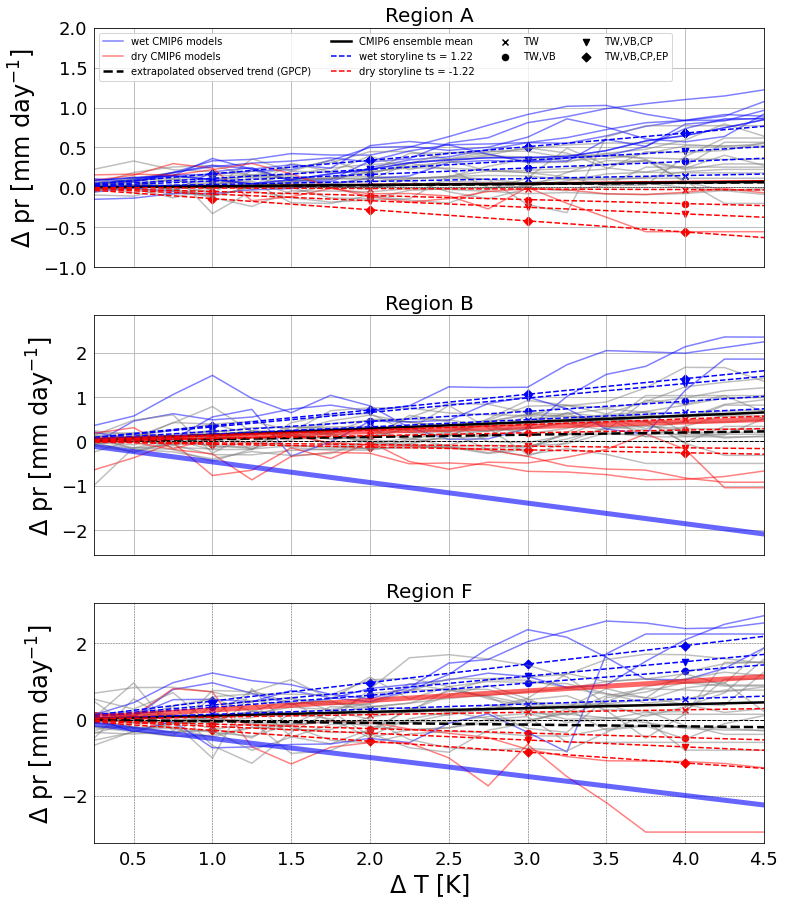

In [26]:
fig = figure()